In [1]:
import os
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

model_name = 'trained_cnn_v1.0_non_adversary_example'

# Import the image that will be used as adversarial example
# Further also load the model, because some of the adversarial example uses gradient information

train_set = np.load('adversarial_example/raw/train_set.npz')
test_set = np.load('adversarial_example/raw/test_set.npz')

# Get sample x and y
x_train, y_train = train_set['x'], train_set['y']
x_test, y_test = test_set['x'], test_set['y'] 

# Every loaded sample set or x_test is normal image which have label 0 : non-adversarial example
#y_test = np.full(shape=len(x_test), fill_value=0)

model = tf.keras.models.load_model(os.path.join('weight', model_name, 'conf_weight.h5'))
model_linear = tf.keras.models.load_model(os.path.join('weight', model_name, 'conf_weight.h5'))

In [2]:
#print(model.get_layer(index=-1).activation)
#model.get_layer(index=-1).activation = tf.keras.activations.linear
#print(model.get_layer(index=-1).activation)
#print(model.layers[-1].output.get_shape())

In [3]:
from collections import Counter
from adversarial_robustness_toolbox.art.estimators.classification import KerasClassifier

def expand_dim(image, label):
    return np.expand_dims(image, axis=0), np.expand_dims(label, axis=0)

def get_tf_classifier(model):
    return KerasClassifier(model=model, clip_values=(0, 1))

# Calculate each class image distribution in each set
def calculate_distribution(y):
    counter = Counter(y)
    for k, v in counter.items():
        per= v / len(y) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

model_linear.get_layer(index=-1).activation = tf.keras.activations.linear

classifier = get_tf_classifier(model=model)
classifier_linear = get_tf_classifier(model=model_linear)

c:\Users\andro\.conda\envs\adversarial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\andro\.conda\envs\adversarial\lib\site-packages\art\estimators\certification\__init__.py:29: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [4]:
print("Train distribution : ")
calculate_distribution(y_train)
print("Test distribution : ")
calculate_distribution(y_test)

Train distribution : 
Class=1, n=545 (33.211%)
Class=0, n=534 (32.541%)
Class=2, n=562 (34.247%)
Test distribution : 
Class=1, n=181 (33.090%)
Class=0, n=178 (32.541%)
Class=2, n=188 (34.369%)


In [5]:
#print(model_linear.get_layer(index=-1).activation)

In [6]:
#tf.keras.utils.to_categorical([1], num_classes=3).shape

In [5]:
# Label 0 : non-adversarial example
# Label 1 : adversarial example : white-box attack
# Label 2 : adversarial example : black-box attack
# Create multiple function of adversarial example

%load_ext autoreload
%autoreload 2

from adversarial_robustness_toolbox.art import attacks

# White-box attack
def fgsm(classifier:KerasClassifier, image, label, epsilon=0.1, group=False, targeted=False):
    if group is not True:
    # Expand dim
        image, label = expand_dim(image, label)

    fgsm_instance = attacks.evasion.FastGradientMethod(estimator=classifier, eps=epsilon, targeted=targeted)
    adversary_example = fgsm_instance.generate(x=image, y=label)

    return adversary_example[0]

def deepfool(classifier:KerasClassifier, image, label, epsilon=0.1, group=False):
    if group is not True:
        # Expand dim
        image, label = expand_dim(image, label)

    # Define deep fool class
    deepfool_instance = attacks.evasion.DeepFool(classifier=classifier, epsilon=epsilon, verbose=False)
    adversary_example = deepfool_instance.generate(x=image, y=label)

    return adversary_example[0]

def wasserstein(classifier:KerasClassifier, image, label, epsilon=0.1, epsilon_factor=1.1, eps_iter=10, group=False, targeted=False):
    if group is not True:
        image, label = expand_dim(image, label)
    
    wasserstein_instance = attacks.evasion.Wasserstein(
        estimator=classifier,
        eps_step=0.1,
        eps=epsilon,
        eps_factor=epsilon_factor,
        regularization=1500.0,
        eps_iter=eps_iter,
        targeted=targeted,
        verbose=False
    )
    adversary_example = wasserstein_instance.generate(x=image, y=label)

    return adversary_example[0]

def carlini(classifier:KerasClassifier, image, label, group=False, type_attack='l2', targeted=False):
    if group is not True:
        image, label = expand_dim(image, label)

    if type_attack == 'l0':
        carlini_instance = attacks.evasion.CarliniL0Method(classifier=classifier, targeted=targeted, verbose=False)
    if type_attack == 'l2':
        carlini_instance = attacks.evasion.CarliniL2Method(classifier=classifier, max_doubling=10, targeted=targeted, verbose=False)
    if type_attack == 'linf':
        carlini_instance = attacks.evasion.CarliniLInfMethod(classifier=classifier, const_factor=4.0, targeted=targeted, verbose=False)

    adversary_example = carlini_instance.generate(x=image, y=label)

    return adversary_example[0]

def elastic_atk(classifier:KerasClassifier, image, label, group=False, targeted=False, binary_search=9):
    if group is not True:
        image, label = expand_dim(image, label)

    elastic_instance = attacks.evasion.ElasticNet(classifier=classifier, binary_search_steps=binary_search, verbose=False)
    adversary_example = elastic_instance.generate(x=image, label=label)

    return adversary_example[0]


'''
def auto_pgd(classifier:KerasClassifier, image, label, group=False):
    if group is not True:
        image, label = expand_dim(image, label)

    # Replace last layer softmax with linear activation function
    auto_pgd_instance = attacks.evasion.AutoProjectedGradientDescent(estimator=classifier)
    adversary_example = auto_pgd_instance.generate(x=image, y=label)

    return adversary_example[0]

def hclu(classifier:KerasClassifier, image, label, group=False):
    if group is not True:
        image, label = expand_dim(image, label)

    hclu_instance = attacks.evasion.HighConfidenceLowUncertainty(classifier=classifier)
    adversary_example = hclu_instance.generate(x=image, y=label)

    return adversary_example[0]


def brendel_bethge(classifier:KerasClassifier, image, label, group=False):
    if group is not True:
    # Expand dim
        image, label = expand_dim(image, label)

    brendel_bethge_instance = attacks.evasion.BrendelBethgeAttack(estimator=classifier)
    adversary_example = brendel_bethge_instance.generate(x=image, y=label)

    return adversary_example[0]
'''

'\ndef auto_pgd(classifier:KerasClassifier, image, label, group=False):\n    if group is not True:\n        image, label = expand_dim(image, label)\n\n    # Replace last layer softmax with linear activation function\n    auto_pgd_instance = attacks.evasion.AutoProjectedGradientDescent(estimator=classifier)\n    adversary_example = auto_pgd_instance.generate(x=image, y=label)\n\n    return adversary_example[0]\n\ndef hclu(classifier:KerasClassifier, image, label, group=False):\n    if group is not True:\n        image, label = expand_dim(image, label)\n\n    hclu_instance = attacks.evasion.HighConfidenceLowUncertainty(classifier=classifier)\n    adversary_example = hclu_instance.generate(x=image, y=label)\n\n    return adversary_example[0]\n\n\ndef brendel_bethge(classifier:KerasClassifier, image, label, group=False):\n    if group is not True:\n    # Expand dim\n        image, label = expand_dim(image, label)\n\n    brendel_bethge_instance = attacks.evasion.BrendelBethgeAttack(estimato

<h2> Demo Adversarial Attack test </h2>

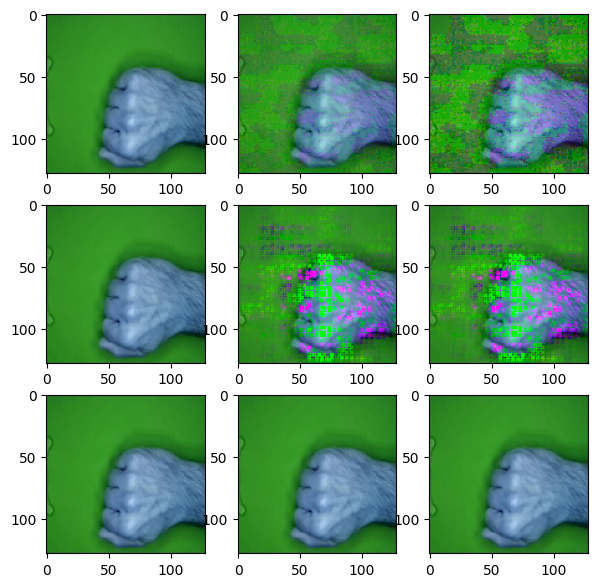

In [7]:
import matplotlib.pyplot as plt

test_image = x_test[0]
label = tf.keras.utils.to_categorical(y_test[0], num_classes=3)
#generated_fgsm = fgsm(model=model, image=test_image, label=label, epsilon=0.05)

width_length_dim = (3, 3)

array_of_adversaries = [test_image]

# FGSM
fig = plt.figure(figsize=(7, 7))
fig.add_subplot(width_length_dim[0], width_length_dim[1], 1)
plt.imshow(test_image)

fgsm1 = fgsm(classifier=classifier, image=test_image, label=label, epsilon=0.05, targeted=False)
array_of_adversaries.append(fgsm1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 2)
plt.imshow(fgsm1)

fgsm2 = fgsm(classifier=classifier, image=test_image, label=label, epsilon=0.1, targeted=False)
array_of_adversaries.append(fgsm2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 3)
plt.imshow(fgsm2)

# deepfool
fig.add_subplot(width_length_dim[0], width_length_dim[1], 4)
plt.imshow(test_image)

deepfool1 = deepfool(classifier=classifier, image=test_image, label=label, epsilon=0.05)
array_of_adversaries.append(deepfool1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 5)
plt.imshow(deepfool1)

deepfool2 = deepfool(classifier=classifier, image=test_image, label=label, epsilon=0.1)
array_of_adversaries.append(deepfool2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 6)
plt.imshow(deepfool2)

'''
# Wasserstein
fig.add_subplot(width_length_dim[0], width_length_dim[1], 7)
plt.imshow(test_image)

wasserstein1 = wasserstein(classifier=classifier, image=test_image, epsilon=0.3, epsilon_factor=1.3, eps_iter=3, label=label, targeted=False)
array_of_adversaries.append(wasserstein1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 8)
plt.imshow(wasserstein1)

wasserstein2 = wasserstein(classifier=classifier, image=test_image, epsilon=0.6, epsilon_factor=1.5, eps_iter=3, label=label, targeted=False)
array_of_adversaries.append(wasserstein2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 9)
plt.imshow(wasserstein2)'''

# Carlini wagner
fig.add_subplot(width_length_dim[0], width_length_dim[1], 7)
plt.imshow(test_image)

cw1 = carlini(classifier=classifier, image=test_image, label=label, type_attack='linf', targeted=False)
array_of_adversaries.append(cw1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 8)
plt.imshow(cw1)

cw2 = carlini(classifier=classifier, image=test_image, label=label, type_attack='l2', targeted=False)
array_of_adversaries.append(cw2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 9)
plt.imshow(cw2)

In [8]:
# Black box attack
def one_pixel_atk(classifier:KerasClassifier, image, label, group=False, targeted=False, es=1):
    if group is not True:
        image, label = expand_dim(image, label)

    one_pixel_instance = attacks.evasion.PixelAttack(classifier=classifier, targeted=targeted, es=es, verbose=False)
    adversary_example = one_pixel_instance.generate(x=image, y=label)

    return adversary_example[0]

def zero_order_atk(classifier:KerasClassifier, image, label, binary_search_steps=1, group=False, targeted=False):
    if group is not True:
        image, label = expand_dim(image, label)

    zoo_attack = attacks.evasion.ZooAttack(classifier=classifier, binary_search_steps=binary_search_steps, abort_early=True, confidence=0.2, targeted=targeted, verbose=False)
    adversary_example = zoo_attack.generate(x=image, y=label)

    return adversary_example[0]

def threshold_atk(classifier:KerasClassifier, image, label, group=False, targeted=False, es=1):
    if group is not True:
        image, label = expand_dim(image, label)

    thresh_attack = attacks.evasion.ThresholdAttack(classifier=classifier, th=5, es=es, targeted=targeted, verbose=False)
    adversary_example = thresh_attack.generate(x=image, y=label)

    return adversary_example[0]

def simba_atk(classifier:KerasClassifier, image, label, group=False, targeted=False, order='random', epsilon=0.1):
    if group is not True:
        image, label = expand_dim(image, label)

    simba_attack = attacks.evasion.SimBA(classifier=classifier, targeted=targeted, order=order, epsilon=epsilon, verbose=False)
    adversary_example = simba_attack.generate(x=image, y=label)

    return adversary_example[0]

def geometrical_da_atk(classifier:KerasClassifier, image, label, group=False, targeted=False, sigma=0.0002):
    if group is not True:
        image, label = expand_dim(image, label)

    geometrical_atk = attacks.evasion.GeoDA(estimator=classifier, sigma=sigma, verbose=False)
    adversary_example = geometrical_atk.generate(x=image, y=label)

    return adversary_example[0]

def square_attack(classifier:KerasClassifier, image, label, group=False, targeted=False, eps=0.3):
    if group is not True:
        image, label = expand_dim(image, label)

    square_attack = attacks.evasion.SquareAttack(estimator=classifier, eps=eps, nb_restarts=2, verbose=False)
    adversary_Example = square_attack.generate(x=image, y=label)

    return adversary_Example[0]
    

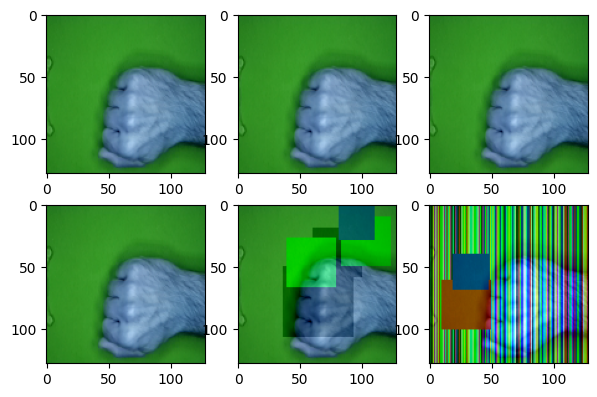

In [9]:
# Elastic Attack
fig = plt.figure(figsize=(7, 7))
fig.add_subplot(width_length_dim[0], width_length_dim[1], 1)
plt.imshow(test_image)

elastic1 = elastic_atk(classifier=classifier, image=test_image, label=label, binary_search=3, targeted=False)
array_of_adversaries.append(elastic1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 2)
plt.imshow(elastic1)

elastic2 = elastic_atk(classifier=classifier, image=test_image, label=label, binary_search=5, targeted=False)
array_of_adversaries.append(elastic2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 3)
plt.imshow(elastic2)

# Square attack
fig.add_subplot(width_length_dim[0], width_length_dim[1], 4)
plt.imshow(test_image)

square1 = square_attack(classifier=classifier, image=test_image, label=label, eps=0.2)
array_of_adversaries.append(square1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 5)
plt.imshow(square1)

square2 = square_attack(classifier=classifier, image=test_image, label=label, eps=0.3)
array_of_adversaries.append(square2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 6)
plt.imshow(square2)

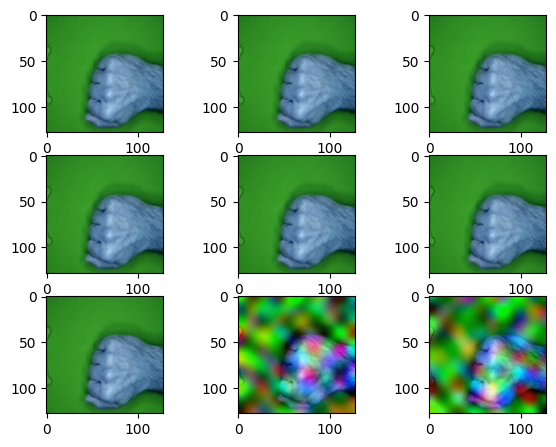

In [10]:
width_length_dim = (4, 3)

fig = plt.figure(figsize=(7, 7))

# One pixel atk
fig.add_subplot(width_length_dim[0], width_length_dim[1], 1)
plt.imshow(test_image)

onepp1 = one_pixel_atk(classifier=classifier, image=test_image, label=label, targeted=False, es=0)
array_of_adversaries.append(onepp1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 2)
plt.imshow(onepp1)

onepp2 = one_pixel_atk(classifier=classifier, image=test_image, label=label, targeted=False, es=1)
array_of_adversaries.append(onepp2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 3)
plt.imshow(onepp2)

# simBA attack
fig.add_subplot(width_length_dim[0], width_length_dim[1], 4)
plt.imshow(test_image)

simba1 = simba_atk(classifier=classifier, image=test_image, label=label, targeted=False, order='random')
array_of_adversaries.append(simba1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 5)
plt.imshow(simba1)

simba2 = simba_atk(classifier=classifier, image=test_image, label=label, targeted=False, order='diag')
array_of_adversaries.append(simba2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 6)
plt.imshow(simba2)

# Geometrical attack
fig.add_subplot(width_length_dim[0], width_length_dim[1], 7)
plt.imshow(test_image)

geo1 = geometrical_da_atk(classifier=classifier, image=test_image, label=label, targeted=False, sigma=0.0003)
array_of_adversaries.append(geo1)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 8)
plt.imshow(geo1)

geo2 = geometrical_da_atk(classifier=classifier, image=test_image, label=label, targeted=False, sigma=0.0006)
array_of_adversaries.append(geo2)
fig.add_subplot(width_length_dim[0], width_length_dim[1], 9)
plt.imshow(geo2)

In [11]:
import cv2

def show_classification_result(image, adversaries, label, adversaries_labels):
    label_format = ['paper', 'rock', 'scissors']

    fig, ax = plt.subplots(len(adversaries), 1)
    ax = ax.flatten()
    fig.set_figheight(30)
    fig.set_figwidth(30)

    output = []
    for idx, adv_ex in enumerate(adversaries):
        img_copy = image.copy()
        color = (0, 255, 0)

        adversary_pred = adversaries_labels[idx].argmax()

        adversary_conf = max(adversaries_labels[idx])
        #print(label_format[label], label_format[adversary_pred], label, adversary_pred)
        if label != adversary_pred:
            color = (0, 0, 255)

        # Pui prediction
        cv2.putText(img_copy, label_format[label], (2, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(adv_ex, label_format[adversary_pred], (2, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        # Put confidence
        cv2.putText(img_copy, str(0), (2, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)
        cv2.putText(adv_ex, str(adversary_conf), (2, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

        output.append(np.hstack((img_copy, adv_ex)))

    for idx, a in enumerate(ax):
        a.imshow(output[idx])

# Predict
predicted = classifier.predict(x=array_of_adversaries)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

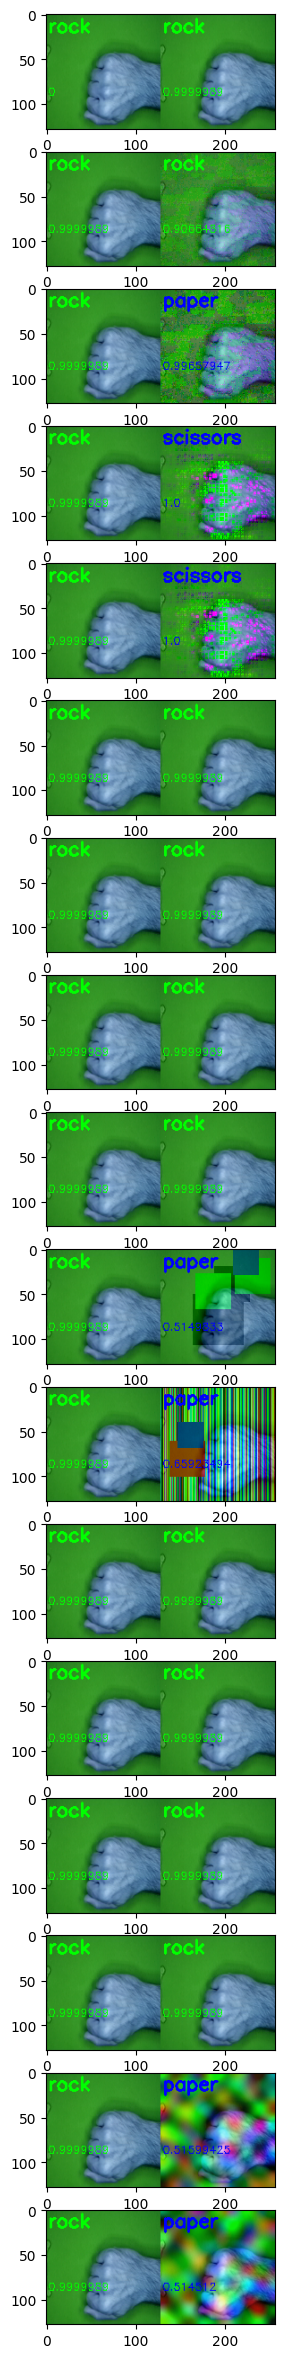

In [12]:
show_classification_result(image=test_image, adversaries=array_of_adversaries, label=y_train[0], adversaries_labels=predicted)

In [24]:
x_test.shape

(547, 128, 128, 3)

In [17]:
import tqdm

def generate_adversarial_example(dataset, dataset_labels, each_class_num):
    def obtain_adversarial_example(img, label, classifier, kind:str='geoda', epsilon:float=0.1, binary_search:int=3, type_attack:str='linf', es:int=0, order:str='diag', sigma:float=0.0003):
        if kind == 'fgsm':
            return fgsm(classifier=classifier, image=img, label=label, epsilon=epsilon), 1
        if kind == 'deepfool':
            return deepfool(classifier=classifier, image=img, label=label, epsilon=epsilon), 1
        if kind == 'elastic':
            return elastic_atk(classifier=classifier, image=img, label=label, binary_search=binary_search, targeted=False), 1
        if kind == 'carlini':
            return carlini(classifier=classifier, image=img, label=label, type_attack=type_attack, targeted=False), 1
        if kind == 'one_pixel':
            return one_pixel_atk(classifier=classifier, image=img, label=label, es=es), 2
        if kind == 'square':
            return square_attack(classifier=classifier, image=img, label=label, eps=epsilon), 2
        if kind == 'simba':
            return simba_atk(classifier=classifier, image=img, label=label, order=order), 2
        if kind == 'geoda':
            return geometrical_da_atk(classifier=classifier, image=img, label=label, sigma=sigma), 2

    categorical_ground_truth = tf.keras.utils.to_categorical(dataset_labels, num_classes=3)

    adversarial_x = []
    adversarial_y = []
    true_y = []

    num_class_zero = 0
    num_class_one = 0
    num_class_two = 0
    for idx, img in tqdm.tqdm(enumerate(dataset)):
        if dataset_labels[idx] == 0:
            if num_class_zero <= each_class_num:
                # Verbose
                print("Iteration : {}, Each Class Num : {}, Label : {}".format(str(idx), str(num_class_zero), str(dataset_labels[idx])))

                # FGSM
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='fgsm', epsilon=0.2)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # deepfool
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='deepfool', epsilon=0.05)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # elastic
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='elastic', binary_search=3)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # carlini
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='carlini', type_attack='linf')
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # one pixel
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='one_pixel', es=0)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # square
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='square', epsilon=0.05)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # Simba
                #adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='simba', order='diag')
                #adversarial_x.append(adv_example)
                #adversarial_y.append(label)

                # Geoda
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='geoda', sigma=0.001)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                num_class_zero += 1
                continue
            else:
                pass
        if dataset_labels[idx] == 1:
            if num_class_one <= each_class_num:
                # Verbose
                print("Iteration : {}, Each Class Num : {}, Label : {}".format(str(idx), str(num_class_one), str(dataset_labels[idx])))

                # FGSM
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='fgsm', epsilon=0.2)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # deepfool
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='deepfool', epsilon=0.05)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # elastic
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='elastic', binary_search=3)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # carlini
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='carlini', type_attack='linf')
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # one pixel
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='one_pixel', es=0)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # square
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='square', epsilon=0.05)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # Simba
                #adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='simba', order='diag')
                #adversarial_x.append(adv_example)
                #adversarial_y.append(label)

                # Geoda
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='geoda', sigma=0.001)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                num_class_one += 1
                continue
            else:
                pass
        if dataset_labels[idx] == 2:
            if num_class_two <= each_class_num:
                # Verbose
                print("Iteration : {}, Each Class Num : {}, Label : {}".format(str(idx), str(num_class_two), str(dataset_labels[idx])))

                # FGSM
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='fgsm', epsilon=0.2)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # deepfool
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='deepfool', epsilon=0.05)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # elastic
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='elastic', binary_search=3)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # carlini
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='carlini', type_attack='linf')
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # one pixel
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='one_pixel', es=0)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # square
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='square', epsilon=0.05)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                # Simba
                #adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='simba', order='diag')
                #adversarial_x.append(adv_example)
                #adversarial_y.append(label)

                # Geoda
                adv_example, label = obtain_adversarial_example(img, categorical_ground_truth[idx], classifier, kind='geoda', sigma=0.001)
                adversarial_x.append(adv_example)
                adversarial_y.append(label)
                true_y.append(dataset_labels[idx])

                num_class_two += 1
                continue
            else:
                pass
    return adversarial_x, adversarial_y, true_y

In [18]:
# Generate for train set
x_test_adv, y_test_adv, true_y = generate_adversarial_example(x_test, dataset_labels=y_test, each_class_num=100)

0it [00:00, ?it/s]

Iteration : 0, Each Class Num : 0, Label : 1


1it [00:14, 14.81s/it]

Iteration : 1, Each Class Num : 1, Label : 1


2it [01:52, 63.56s/it]

Iteration : 2, Each Class Num : 2, Label : 1


3it [02:08, 41.92s/it]

Iteration : 3, Each Class Num : 3, Label : 1


4it [03:48, 64.61s/it]

Iteration : 4, Each Class Num : 4, Label : 1


5it [05:16, 73.18s/it]

Iteration : 5, Each Class Num : 5, Label : 1


6it [05:38, 55.75s/it]

Iteration : 6, Each Class Num : 6, Label : 1


7it [05:54, 42.79s/it]

Iteration : 7, Each Class Num : 7, Label : 1


8it [06:17, 36.56s/it]

Iteration : 8, Each Class Num : 8, Label : 1


9it [06:33, 30.21s/it]

Iteration : 9, Each Class Num : 9, Label : 1


10it [06:50, 25.93s/it]

Iteration : 10, Each Class Num : 10, Label : 1


11it [08:29, 48.42s/it]

Iteration : 11, Each Class Num : 11, Label : 1


12it [09:11, 46.38s/it]

Iteration : 12, Each Class Num : 12, Label : 1


13it [10:50, 62.24s/it]

Iteration : 13, Each Class Num : 13, Label : 1


14it [11:06, 48.33s/it]

Iteration : 14, Each Class Num : 14, Label : 1


15it [11:23, 38.83s/it]

Iteration : 15, Each Class Num : 15, Label : 1


16it [11:39, 32.08s/it]

Iteration : 16, Each Class Num : 16, Label : 1


17it [11:55, 27.32s/it]

Iteration : 17, Each Class Num : 17, Label : 1


18it [13:35, 49.14s/it]

Iteration : 18, Each Class Num : 18, Label : 1


19it [14:30, 50.73s/it]

Iteration : 19, Each Class Num : 19, Label : 1


20it [14:53, 42.57s/it]

Iteration : 20, Each Class Num : 20, Label : 1


21it [16:11, 53.10s/it]

Iteration : 21, Each Class Num : 21, Label : 1


22it [17:49, 66.66s/it]

Iteration : 22, Each Class Num : 22, Label : 1


23it [19:28, 76.44s/it]

Iteration : 23, Each Class Num : 23, Label : 1


24it [19:45, 58.41s/it]

Iteration : 24, Each Class Num : 24, Label : 1


25it [21:23, 70.41s/it]

Iteration : 25, Each Class Num : 25, Label : 1


26it [21:39, 54.18s/it]

Iteration : 26, Each Class Num : 26, Label : 1


27it [23:16, 67.03s/it]

Iteration : 27, Each Class Num : 27, Label : 1


28it [24:40, 72.02s/it]

Iteration : 28, Each Class Num : 28, Label : 1


29it [24:55, 55.01s/it]

Iteration : 29, Each Class Num : 29, Label : 1


30it [26:21, 64.12s/it]

Iteration : 30, Each Class Num : 30, Label : 1


31it [27:56, 73.30s/it]

Iteration : 31, Each Class Num : 31, Label : 1


32it [28:11, 55.85s/it]

Iteration : 32, Each Class Num : 32, Label : 1


33it [29:45, 67.29s/it]

Iteration : 33, Each Class Num : 33, Label : 1


34it [30:00, 51.65s/it]

Iteration : 34, Each Class Num : 34, Label : 1


35it [31:01, 54.40s/it]

Iteration : 35, Each Class Num : 35, Label : 1


36it [32:35, 66.44s/it]

Iteration : 36, Each Class Num : 36, Label : 1


37it [32:50, 51.01s/it]

Iteration : 37, Each Class Num : 37, Label : 1


38it [34:25, 64.02s/it]

Iteration : 38, Each Class Num : 38, Label : 1


39it [36:05, 75.04s/it]

Iteration : 39, Each Class Num : 39, Label : 1


40it [36:21, 57.14s/it]

Iteration : 40, Each Class Num : 40, Label : 1


41it [36:36, 44.51s/it]

Iteration : 41, Each Class Num : 41, Label : 1


42it [37:40, 50.57s/it]

Iteration : 42, Each Class Num : 42, Label : 1


43it [39:07, 61.36s/it]

Iteration : 43, Each Class Num : 43, Label : 1


44it [39:22, 47.47s/it]

Iteration : 44, Each Class Num : 44, Label : 1


45it [39:37, 37.63s/it]

Iteration : 45, Each Class Num : 45, Label : 1


46it [41:11, 54.61s/it]

Iteration : 46, Each Class Num : 46, Label : 1


47it [41:26, 42.79s/it]

Iteration : 47, Each Class Num : 47, Label : 1


48it [41:41, 34.44s/it]

Iteration : 48, Each Class Num : 48, Label : 1


49it [42:57, 46.89s/it]

Iteration : 49, Each Class Num : 49, Label : 1


50it [43:12, 37.24s/it]

Iteration : 50, Each Class Num : 50, Label : 1


51it [43:27, 30.68s/it]

Iteration : 51, Each Class Num : 51, Label : 1


52it [45:04, 50.65s/it]

Iteration : 52, Each Class Num : 52, Label : 1


53it [46:40, 64.17s/it]

Iteration : 53, Each Class Num : 53, Label : 1


54it [48:07, 71.06s/it]

Iteration : 54, Each Class Num : 54, Label : 1


55it [48:22, 54.23s/it]

Iteration : 55, Each Class Num : 55, Label : 1


56it [48:43, 44.14s/it]

Iteration : 56, Each Class Num : 56, Label : 1


57it [50:10, 57.04s/it]

Iteration : 57, Each Class Num : 57, Label : 1


58it [51:46, 68.77s/it]

Iteration : 58, Each Class Num : 58, Label : 1


59it [53:22, 77.01s/it]

Iteration : 59, Each Class Num : 59, Label : 1


60it [54:58, 82.70s/it]

Iteration : 60, Each Class Num : 60, Label : 1


61it [55:14, 62.50s/it]

Iteration : 61, Each Class Num : 61, Label : 1


62it [55:41, 51.93s/it]

Iteration : 62, Each Class Num : 62, Label : 1


63it [55:56, 40.95s/it]

Iteration : 63, Each Class Num : 63, Label : 1


64it [56:11, 33.22s/it]

Iteration : 64, Each Class Num : 64, Label : 1


65it [57:29, 46.38s/it]

Iteration : 65, Each Class Num : 65, Label : 1


66it [57:44, 37.08s/it]

Iteration : 66, Each Class Num : 66, Label : 1


67it [57:59, 30.60s/it]

Iteration : 67, Each Class Num : 67, Label : 1


68it [58:15, 26.07s/it]

Iteration : 68, Each Class Num : 68, Label : 1


69it [58:30, 22.89s/it]

Iteration : 69, Each Class Num : 69, Label : 1


70it [58:46, 20.68s/it]

Iteration : 70, Each Class Num : 70, Label : 1


71it [1:00:21, 43.17s/it]

Iteration : 71, Each Class Num : 71, Label : 1


72it [1:00:39, 35.52s/it]

Iteration : 72, Each Class Num : 72, Label : 1


73it [1:00:53, 29.15s/it]

Iteration : 73, Each Class Num : 73, Label : 1


74it [1:01:09, 24.96s/it]

Iteration : 74, Each Class Num : 74, Label : 1


75it [1:02:41, 45.23s/it]

Iteration : 75, Each Class Num : 75, Label : 1


76it [1:04:13, 59.21s/it]

Iteration : 76, Each Class Num : 76, Label : 1


77it [1:05:47, 69.66s/it]

Iteration : 77, Each Class Num : 77, Label : 1


78it [1:07:20, 76.51s/it]

Iteration : 78, Each Class Num : 78, Label : 1


79it [1:08:51, 80.93s/it]

Iteration : 79, Each Class Num : 79, Label : 1


80it [1:10:22, 84.06s/it]

Iteration : 80, Each Class Num : 80, Label : 1


81it [1:11:54, 86.28s/it]

Iteration : 81, Each Class Num : 81, Label : 1


82it [1:13:26, 88.06s/it]

Iteration : 82, Each Class Num : 82, Label : 1


83it [1:13:41, 66.12s/it]

Iteration : 83, Each Class Num : 83, Label : 1


84it [1:13:56, 50.82s/it]

Iteration : 84, Each Class Num : 84, Label : 1


85it [1:15:10, 57.81s/it]

Iteration : 85, Each Class Num : 85, Label : 1


86it [1:15:25, 44.96s/it]

Iteration : 86, Each Class Num : 86, Label : 1


87it [1:16:18, 47.40s/it]

Iteration : 87, Each Class Num : 87, Label : 1


88it [1:17:42, 58.36s/it]

Iteration : 88, Each Class Num : 88, Label : 1


89it [1:19:15, 68.78s/it]

Iteration : 89, Each Class Num : 89, Label : 1


90it [1:19:30, 52.63s/it]

Iteration : 90, Each Class Num : 90, Label : 1


91it [1:21:04, 65.03s/it]

Iteration : 91, Each Class Num : 91, Label : 1


92it [1:21:19, 50.08s/it]

Iteration : 92, Each Class Num : 92, Label : 1


93it [1:22:53, 63.21s/it]

Iteration : 93, Each Class Num : 93, Label : 1


94it [1:23:09, 48.90s/it]

Iteration : 94, Each Class Num : 94, Label : 1


95it [1:24:44, 62.80s/it]

Iteration : 95, Each Class Num : 95, Label : 1


96it [1:24:59, 48.59s/it]

Iteration : 96, Each Class Num : 96, Label : 1


97it [1:26:33, 62.05s/it]

Iteration : 97, Each Class Num : 97, Label : 1


98it [1:28:07, 71.60s/it]

Iteration : 98, Each Class Num : 98, Label : 1


99it [1:28:21, 54.57s/it]

Iteration : 99, Each Class Num : 99, Label : 1


100it [1:28:37, 42.82s/it]

Iteration : 100, Each Class Num : 100, Label : 1


101it [1:30:10, 57.99s/it]

Iteration : 181, Each Class Num : 0, Label : 0


182it [1:31:44,  2.75s/it]

Iteration : 182, Each Class Num : 1, Label : 0


183it [1:33:22,  4.35s/it]

Iteration : 183, Each Class Num : 2, Label : 0


184it [1:35:00,  6.56s/it]

Iteration : 184, Each Class Num : 3, Label : 0


185it [1:36:35,  9.45s/it]

Iteration : 185, Each Class Num : 4, Label : 0


186it [1:38:11, 13.27s/it]

Iteration : 186, Each Class Num : 5, Label : 0


187it [1:39:45, 18.10s/it]

Iteration : 187, Each Class Num : 6, Label : 0


188it [1:41:21, 24.15s/it]

Iteration : 188, Each Class Num : 7, Label : 0


189it [1:42:58, 31.49s/it]

Iteration : 189, Each Class Num : 8, Label : 0


190it [1:44:34, 39.67s/it]

Iteration : 190, Each Class Num : 9, Label : 0


191it [1:46:10, 48.25s/it]

Iteration : 191, Each Class Num : 10, Label : 0


192it [1:47:50, 57.44s/it]

Iteration : 192, Each Class Num : 11, Label : 0


193it [1:49:27, 65.54s/it]

Iteration : 193, Each Class Num : 12, Label : 0


194it [1:51:03, 72.34s/it]

Iteration : 194, Each Class Num : 13, Label : 0


195it [1:52:40, 78.29s/it]

Iteration : 195, Each Class Num : 14, Label : 0


196it [1:52:54, 61.72s/it]

Iteration : 196, Each Class Num : 15, Label : 0


197it [1:53:48, 59.83s/it]

Iteration : 197, Each Class Num : 16, Label : 0


198it [1:54:06, 48.08s/it]

Iteration : 198, Each Class Num : 17, Label : 0


199it [1:55:42, 61.65s/it]

Iteration : 199, Each Class Num : 18, Label : 0


200it [1:57:19, 71.84s/it]

Iteration : 200, Each Class Num : 19, Label : 0


201it [1:58:11, 66.21s/it]

Iteration : 201, Each Class Num : 20, Label : 0


202it [1:59:45, 74.35s/it]

Iteration : 202, Each Class Num : 21, Label : 0


203it [2:01:22, 81.02s/it]

Iteration : 203, Each Class Num : 22, Label : 0


204it [2:03:02, 86.56s/it]

Iteration : 204, Each Class Num : 23, Label : 0


205it [2:04:39, 89.73s/it]

Iteration : 205, Each Class Num : 24, Label : 0


206it [2:06:16, 92.10s/it]

Iteration : 206, Each Class Num : 25, Label : 0


207it [2:07:53, 93.49s/it]

Iteration : 207, Each Class Num : 26, Label : 0


208it [2:09:26, 93.39s/it]

Iteration : 208, Each Class Num : 27, Label : 0


209it [2:11:03, 94.52s/it]

Iteration : 209, Each Class Num : 28, Label : 0


210it [2:12:38, 94.43s/it]

Iteration : 210, Each Class Num : 29, Label : 0


211it [2:14:15, 95.41s/it]

Iteration : 211, Each Class Num : 30, Label : 0


212it [2:15:54, 96.47s/it]

Iteration : 212, Each Class Num : 31, Label : 0


213it [2:16:13, 73.06s/it]

Iteration : 213, Each Class Num : 32, Label : 0


214it [2:17:50, 80.41s/it]

Iteration : 214, Each Class Num : 33, Label : 0


215it [2:19:31, 86.62s/it]

Iteration : 215, Each Class Num : 34, Label : 0


216it [2:21:13, 91.11s/it]

Iteration : 216, Each Class Num : 35, Label : 0


217it [2:22:53, 93.87s/it]

Iteration : 217, Each Class Num : 36, Label : 0


218it [2:24:39, 97.29s/it]

Iteration : 218, Each Class Num : 37, Label : 0


219it [2:26:24, 99.84s/it]

Iteration : 219, Each Class Num : 38, Label : 0


220it [2:28:10, 101.65s/it]

Iteration : 220, Each Class Num : 39, Label : 0


221it [2:29:53, 102.06s/it]

Iteration : 221, Each Class Num : 40, Label : 0


222it [2:31:35, 102.04s/it]

Iteration : 222, Each Class Num : 41, Label : 0


223it [2:33:17, 101.98s/it]

Iteration : 223, Each Class Num : 42, Label : 0


224it [2:34:57, 101.38s/it]

Iteration : 224, Each Class Num : 43, Label : 0


225it [2:36:42, 102.47s/it]

Iteration : 225, Each Class Num : 44, Label : 0


226it [2:38:29, 103.67s/it]

Iteration : 226, Each Class Num : 45, Label : 0


227it [2:38:47, 78.21s/it] 

Iteration : 227, Each Class Num : 46, Label : 0


228it [2:40:32, 85.99s/it]

Iteration : 228, Each Class Num : 47, Label : 0


229it [2:42:14, 90.95s/it]

Iteration : 229, Each Class Num : 48, Label : 0


230it [2:43:57, 94.58s/it]

Iteration : 230, Each Class Num : 49, Label : 0


231it [2:45:39, 96.72s/it]

Iteration : 231, Each Class Num : 50, Label : 0


232it [2:47:23, 98.82s/it]

Iteration : 232, Each Class Num : 51, Label : 0


233it [2:49:03, 99.45s/it]

Iteration : 233, Each Class Num : 52, Label : 0


234it [2:50:50, 101.60s/it]

Iteration : 234, Each Class Num : 53, Label : 0


235it [2:52:33, 101.93s/it]

Iteration : 235, Each Class Num : 54, Label : 0


236it [2:54:16, 102.36s/it]

Iteration : 236, Each Class Num : 55, Label : 0


237it [2:56:00, 102.86s/it]

Iteration : 237, Each Class Num : 56, Label : 0


238it [2:57:47, 104.13s/it]

Iteration : 238, Each Class Num : 57, Label : 0


239it [2:59:38, 105.97s/it]

Iteration : 239, Each Class Num : 58, Label : 0


240it [3:01:22, 105.38s/it]

Iteration : 240, Each Class Num : 59, Label : 0


241it [3:03:08, 105.78s/it]

Iteration : 241, Each Class Num : 60, Label : 0


242it [3:04:54, 105.74s/it]

Iteration : 242, Each Class Num : 61, Label : 0


243it [3:06:41, 106.19s/it]

Iteration : 243, Each Class Num : 62, Label : 0


244it [3:07:27, 88.22s/it] 

Iteration : 244, Each Class Num : 63, Label : 0


245it [3:07:48, 68.03s/it]

Iteration : 245, Each Class Num : 64, Label : 0


246it [3:09:25, 76.74s/it]

Iteration : 246, Each Class Num : 65, Label : 0


247it [3:11:07, 84.14s/it]

Iteration : 247, Each Class Num : 66, Label : 0


248it [3:11:51, 72.16s/it]

Iteration : 248, Each Class Num : 67, Label : 0


249it [3:13:37, 82.43s/it]

Iteration : 249, Each Class Num : 68, Label : 0


250it [3:15:21, 88.75s/it]

Iteration : 250, Each Class Num : 69, Label : 0


251it [3:17:04, 93.19s/it]

Iteration : 251, Each Class Num : 70, Label : 0


252it [3:18:47, 96.13s/it]

Iteration : 252, Each Class Num : 71, Label : 0


253it [3:20:30, 97.98s/it]

Iteration : 253, Each Class Num : 72, Label : 0


254it [3:20:44, 72.95s/it]

Iteration : 254, Each Class Num : 73, Label : 0


255it [3:22:24, 80.96s/it]

Iteration : 255, Each Class Num : 74, Label : 0


256it [3:24:04, 86.71s/it]

Iteration : 256, Each Class Num : 75, Label : 0


257it [3:25:51, 92.78s/it]

Iteration : 257, Each Class Num : 76, Label : 0


258it [3:27:30, 94.67s/it]

Iteration : 258, Each Class Num : 77, Label : 0


259it [3:29:10, 96.16s/it]

Iteration : 259, Each Class Num : 78, Label : 0


260it [3:30:48, 96.78s/it]

Iteration : 260, Each Class Num : 79, Label : 0


261it [3:32:28, 97.77s/it]

Iteration : 261, Each Class Num : 80, Label : 0


262it [3:33:49, 92.69s/it]

Iteration : 262, Each Class Num : 81, Label : 0


263it [3:35:30, 95.29s/it]

Iteration : 263, Each Class Num : 82, Label : 0


264it [3:37:12, 97.10s/it]

Iteration : 264, Each Class Num : 83, Label : 0


265it [3:38:54, 98.58s/it]

Iteration : 265, Each Class Num : 84, Label : 0


266it [3:39:17, 76.07s/it]

Iteration : 266, Each Class Num : 85, Label : 0


267it [3:40:56, 83.01s/it]

Iteration : 267, Each Class Num : 86, Label : 0


268it [3:42:35, 87.81s/it]

Iteration : 268, Each Class Num : 87, Label : 0


269it [3:42:58, 68.23s/it]

Iteration : 269, Each Class Num : 88, Label : 0


270it [3:44:40, 78.42s/it]

Iteration : 270, Each Class Num : 89, Label : 0


271it [3:46:12, 82.37s/it]

Iteration : 271, Each Class Num : 90, Label : 0


272it [3:47:54, 88.31s/it]

Iteration : 272, Each Class Num : 91, Label : 0


273it [3:49:36, 92.43s/it]

Iteration : 273, Each Class Num : 92, Label : 0


274it [3:51:15, 94.53s/it]

Iteration : 274, Each Class Num : 93, Label : 0


275it [3:52:57, 96.66s/it]

Iteration : 275, Each Class Num : 94, Label : 0


276it [3:54:30, 95.71s/it]

Iteration : 276, Each Class Num : 95, Label : 0


277it [3:56:06, 95.76s/it]

Iteration : 277, Each Class Num : 96, Label : 0


278it [3:57:49, 97.84s/it]

Iteration : 278, Each Class Num : 97, Label : 0


279it [3:58:16, 76.57s/it]

Iteration : 279, Each Class Num : 98, Label : 0


280it [3:59:55, 83.36s/it]

Iteration : 280, Each Class Num : 99, Label : 0


281it [4:01:38, 89.25s/it]

Iteration : 281, Each Class Num : 100, Label : 0


282it [4:03:18, 92.52s/it]

Iteration : 359, Each Class Num : 0, Label : 2


360it [4:03:39,  2.94s/it]

Iteration : 360, Each Class Num : 1, Label : 2


361it [4:03:56,  3.19s/it]

Iteration : 361, Each Class Num : 2, Label : 2


362it [4:04:13,  3.54s/it]

Iteration : 362, Each Class Num : 3, Label : 2


363it [4:04:31,  4.03s/it]

Iteration : 363, Each Class Num : 4, Label : 2


364it [4:04:50,  4.68s/it]

Iteration : 364, Each Class Num : 5, Label : 2


365it [4:05:10,  5.61s/it]

Iteration : 365, Each Class Num : 6, Label : 2


366it [4:05:29,  6.73s/it]

Iteration : 366, Each Class Num : 7, Label : 2


367it [4:05:48,  7.98s/it]

Iteration : 367, Each Class Num : 8, Label : 2


368it [4:06:07,  9.37s/it]

Iteration : 368, Each Class Num : 9, Label : 2


369it [4:06:24, 10.60s/it]

Iteration : 369, Each Class Num : 10, Label : 2


370it [4:06:43, 12.13s/it]

Iteration : 370, Each Class Num : 11, Label : 2


371it [4:07:03, 13.72s/it]

Iteration : 371, Each Class Num : 12, Label : 2


372it [4:08:44, 33.66s/it]

Iteration : 372, Each Class Num : 13, Label : 2


373it [4:09:02, 29.72s/it]

Iteration : 373, Each Class Num : 14, Label : 2


374it [4:09:22, 27.13s/it]

Iteration : 374, Each Class Num : 15, Label : 2


375it [4:09:41, 25.06s/it]

Iteration : 375, Each Class Num : 16, Label : 2


376it [4:10:00, 23.50s/it]

Iteration : 376, Each Class Num : 17, Label : 2


377it [4:10:20, 22.47s/it]

Iteration : 377, Each Class Num : 18, Label : 2


378it [4:10:38, 21.16s/it]

Iteration : 378, Each Class Num : 19, Label : 2


379it [4:10:59, 21.09s/it]

Iteration : 379, Each Class Num : 20, Label : 2


380it [4:11:20, 21.08s/it]

Iteration : 380, Each Class Num : 21, Label : 2


381it [4:11:38, 19.95s/it]

Iteration : 381, Each Class Num : 22, Label : 2


382it [4:13:17, 43.61s/it]

Iteration : 382, Each Class Num : 23, Label : 2


383it [4:14:53, 59.26s/it]

Iteration : 383, Each Class Num : 24, Label : 2


384it [4:15:10, 46.45s/it]

Iteration : 384, Each Class Num : 25, Label : 2


385it [4:15:28, 38.13s/it]

Iteration : 385, Each Class Num : 26, Label : 2


386it [4:15:45, 31.67s/it]

Iteration : 386, Each Class Num : 27, Label : 2


387it [4:16:02, 27.36s/it]

Iteration : 387, Each Class Num : 28, Label : 2


388it [4:16:20, 24.67s/it]

Iteration : 388, Each Class Num : 29, Label : 2


389it [4:16:38, 22.51s/it]

Iteration : 389, Each Class Num : 30, Label : 2


390it [4:16:56, 21.23s/it]

Iteration : 390, Each Class Num : 31, Label : 2


391it [4:17:12, 19.74s/it]

Iteration : 391, Each Class Num : 32, Label : 2


392it [4:17:29, 18.92s/it]

Iteration : 392, Each Class Num : 33, Label : 2


393it [4:17:48, 18.82s/it]

Iteration : 393, Each Class Num : 34, Label : 2


394it [4:18:07, 18.83s/it]

Iteration : 394, Each Class Num : 35, Label : 2


395it [4:18:25, 18.55s/it]

Iteration : 395, Each Class Num : 36, Label : 2


396it [4:18:41, 18.02s/it]

Iteration : 396, Each Class Num : 37, Label : 2


397it [4:19:00, 18.27s/it]

Iteration : 397, Each Class Num : 38, Label : 2


398it [4:19:17, 17.84s/it]

Iteration : 398, Each Class Num : 39, Label : 2


399it [4:19:37, 18.44s/it]

Iteration : 399, Each Class Num : 40, Label : 2


400it [4:19:55, 18.39s/it]

Iteration : 400, Each Class Num : 41, Label : 2


401it [4:21:41, 44.57s/it]

Iteration : 401, Each Class Num : 42, Label : 2


402it [4:22:00, 36.92s/it]

Iteration : 402, Each Class Num : 43, Label : 2


403it [4:22:20, 31.88s/it]

Iteration : 403, Each Class Num : 44, Label : 2


404it [4:22:38, 27.68s/it]

Iteration : 404, Each Class Num : 45, Label : 2


405it [4:24:23, 50.79s/it]

Iteration : 405, Each Class Num : 46, Label : 2


406it [4:24:41, 41.18s/it]

Iteration : 406, Each Class Num : 47, Label : 2


407it [4:24:59, 34.09s/it]

Iteration : 407, Each Class Num : 48, Label : 2


408it [4:25:20, 30.03s/it]

Iteration : 408, Each Class Num : 49, Label : 2


409it [4:25:37, 26.26s/it]

Iteration : 409, Each Class Num : 50, Label : 2


410it [4:25:55, 23.75s/it]

Iteration : 410, Each Class Num : 51, Label : 2


411it [4:26:13, 22.02s/it]

Iteration : 411, Each Class Num : 52, Label : 2


412it [4:26:31, 20.87s/it]

Iteration : 412, Each Class Num : 53, Label : 2


413it [4:26:51, 20.54s/it]

Iteration : 413, Each Class Num : 54, Label : 2


414it [4:27:11, 20.30s/it]

Iteration : 414, Each Class Num : 55, Label : 2


415it [4:27:31, 20.27s/it]

Iteration : 415, Each Class Num : 56, Label : 2


416it [4:27:51, 20.36s/it]

Iteration : 416, Each Class Num : 57, Label : 2


417it [4:28:12, 20.39s/it]

Iteration : 417, Each Class Num : 58, Label : 2


418it [4:28:30, 19.75s/it]

Iteration : 418, Each Class Num : 59, Label : 2


419it [4:28:48, 19.26s/it]

Iteration : 419, Each Class Num : 60, Label : 2


420it [4:29:14, 21.10s/it]

Iteration : 420, Each Class Num : 61, Label : 2


421it [4:29:32, 20.37s/it]

Iteration : 421, Each Class Num : 62, Label : 2


422it [4:29:50, 19.60s/it]

Iteration : 422, Each Class Num : 63, Label : 2


423it [4:30:10, 19.69s/it]

Iteration : 423, Each Class Num : 64, Label : 2


424it [4:30:27, 18.99s/it]

Iteration : 424, Each Class Num : 65, Label : 2


425it [4:30:48, 19.46s/it]

Iteration : 425, Each Class Num : 66, Label : 2


426it [4:31:06, 19.18s/it]

Iteration : 426, Each Class Num : 67, Label : 2


427it [4:31:25, 19.11s/it]

Iteration : 427, Each Class Num : 68, Label : 2


428it [4:31:44, 19.05s/it]

Iteration : 428, Each Class Num : 69, Label : 2


429it [4:32:05, 19.54s/it]

Iteration : 429, Each Class Num : 70, Label : 2


430it [4:33:55, 46.60s/it]

Iteration : 430, Each Class Num : 71, Label : 2


431it [4:34:14, 38.46s/it]

Iteration : 431, Each Class Num : 72, Label : 2


432it [4:34:34, 32.99s/it]

Iteration : 432, Each Class Num : 73, Label : 2


433it [4:34:53, 28.58s/it]

Iteration : 433, Each Class Num : 74, Label : 2


434it [4:35:13, 26.18s/it]

Iteration : 434, Each Class Num : 75, Label : 2


435it [4:35:35, 24.81s/it]

Iteration : 435, Each Class Num : 76, Label : 2


436it [4:37:29, 51.67s/it]

Iteration : 436, Each Class Num : 77, Label : 2


437it [4:37:47, 41.46s/it]

Iteration : 437, Each Class Num : 78, Label : 2


438it [4:38:07, 35.06s/it]

Iteration : 438, Each Class Num : 79, Label : 2


439it [4:38:27, 30.57s/it]

Iteration : 439, Each Class Num : 80, Label : 2


440it [4:38:45, 26.84s/it]

Iteration : 440, Each Class Num : 81, Label : 2


441it [4:39:05, 24.74s/it]

Iteration : 441, Each Class Num : 82, Label : 2


442it [4:39:23, 22.60s/it]

Iteration : 442, Each Class Num : 83, Label : 2


443it [4:39:40, 21.09s/it]

Iteration : 443, Each Class Num : 84, Label : 2


444it [4:40:00, 20.62s/it]

Iteration : 444, Each Class Num : 85, Label : 2


445it [4:41:45, 45.95s/it]

Iteration : 445, Each Class Num : 86, Label : 2


446it [4:42:04, 37.79s/it]

Iteration : 446, Each Class Num : 87, Label : 2


447it [4:42:22, 31.85s/it]

Iteration : 447, Each Class Num : 88, Label : 2


448it [4:42:40, 27.86s/it]

Iteration : 448, Each Class Num : 89, Label : 2


449it [4:42:58, 24.86s/it]

Iteration : 449, Each Class Num : 90, Label : 2


450it [4:43:16, 22.88s/it]

Iteration : 450, Each Class Num : 91, Label : 2


451it [4:43:34, 21.44s/it]

Iteration : 451, Each Class Num : 92, Label : 2


452it [4:43:54, 21.02s/it]

Iteration : 452, Each Class Num : 93, Label : 2


453it [4:44:14, 20.71s/it]

Iteration : 453, Each Class Num : 94, Label : 2


454it [4:44:33, 19.95s/it]

Iteration : 454, Each Class Num : 95, Label : 2


455it [4:44:50, 19.32s/it]

Iteration : 455, Each Class Num : 96, Label : 2


456it [4:45:08, 18.88s/it]

Iteration : 456, Each Class Num : 97, Label : 2


457it [4:45:26, 18.69s/it]

Iteration : 457, Each Class Num : 98, Label : 2


458it [4:45:46, 19.01s/it]

Iteration : 458, Each Class Num : 99, Label : 2


459it [4:47:31, 44.84s/it]

Iteration : 459, Each Class Num : 100, Label : 2


547it [4:47:52, 31.58s/it]


In [19]:
x_test_adv, y_test_adv, true_y = np.array(x_test_adv), np.array(y_test_adv), np.array(true_y)

In [20]:
len(true_y)

2121

In [16]:
x_test_adv.shape

(2121, 128, 128, 3)

In [45]:
np.savez('adversarial_example/generated/test_set_with_original_label.npz',x=x_test_adv, y=y_test_adv, y_true=true_y)